# Setup

In [98]:
import numpy as np
import pandas as pd
import pybaseball
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import gammaln
from scipy.optimize import minimize

# Load data from Chapter 3

In [99]:
# Load dataframe
bd = pd.read_pickle("./data/batting_data_ebestimate.pkl")

# Load beta parameters
with open("./data/eb_estimate_beta_params.npy","rb") as f:
    alpha0, beta0 = np.load(f)

# Posterior distribution for each batter

In [100]:
bd["alpha1"] = bd.apply(lambda row: alpha0 + row.H,axis=1)
bd["beta1"] = bd.apply(lambda row: beta0 + row.AB - row.H,axis=1)

# Figure 4.1 (color order does not match)

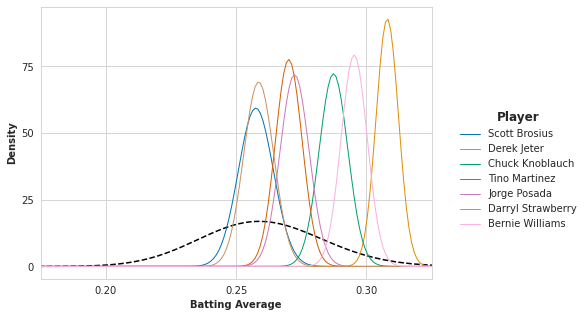

In [101]:
# Which players
players = ["Bernie Williams", "Chuck Knoblauch", "Darryl Strawberry", "Derek Jeter", "Jorge Posada", "Scott Brosius", "Tino Martinez"]

# Make figure
with sns.axes_style("whitegrid"):
    # Fig
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()
    clrs = sns.color_palette("colorblind",n_colors=len(players))

    # Make distributions for prior and each player
    x = np.linspace(0,1,1000)
    ax.plot(x, stats.beta.pdf(x,alpha0,beta0),color='k',linestyle='--')
    for (row,clr) in zip(bd.loc[(bd.Name.isin(players)) & (bd.AB > 500),:].itertuples(),clrs):
        ax.plot(x,stats.beta.pdf(x,row.alpha1,row.beta1),color=clr,lw=1,label=row.Name)
    ax.set_xlim(0.175,0.325)

    # Add legend and clean up
    ax.legend(frameon=False,bbox_to_anchor=(1.05, .65),loc='upper left')
    ax.get_legend().set_title("Player",prop = {'size':12,'weight': "bold"})
    ax.set_xlabel("Batting Average",fontweight="bold")
    ax.set_ylabel("Density",fontweight="bold")
    ax.set_xticks([.2,.25, .3])
    ax.set_yticks([0,25,50,75])


Add the credible intervals for each player

In [102]:
def get_credible_intervals(data,ci=[0.025,0.975]):
        # Get explicit credible intervals
        data["ci_low"], data["ci_high"] = stats.beta.ppf(ci,data["alpha1"],data["beta1"])
        # Get difference between mean and CIs since that is what matplotlib.pyplot.errorbar wants
        data["ci_low_diff"], data["ci_high_diff"] = np.absolute(data["Avg"]-data["ci_low"]), np.absolute(data["Avg"]-data["ci_high"])
        
        return data

# bd = bd.append(["ci_low","ci_high"])
bd = bd.apply(get_credible_intervals,axis=1)

# Get trimed dataframe
bd_trim = bd.loc[(bd.Name.isin(players)) & (bd.AB > 500),:].sort_values(by="Avg",ascending=True).copy()
bd_trim

/Users/justinbrantley/miniconda3/envs/bayesball/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


,playerID,AB,H,Name,Avg,eb estimate Avg,alpha1,beta1,ci_low,ci_high,ci_low_diff,ci_high_diff
1023,brosisc01,3889,1001,Scott Brosius,0.257393,0.257621,1090.733185,3143.130635,0.244559,0.270900,0.012833,0.013507
8575,strawda01,5418,1401,Darryl Strawberry,0.258583,0.258679,1490.733185,4272.130635,0.247454,0.270063,0.011128,0.011481
5535,martiti02,7111,1925,Tino Martinez,0.270707,0.270221,2014.733185,5441.130635,0.260201,0.280358,0.010506,0.009651
7071,posadjo01,6092,1664,Jorge Posada,0.273145,0.272451,1753.733185,4683.130635,0.261643,0.283394,0.011502,0.010248
4758,knoblch01,6366,1839,Chuck Knoblauch,0.288878,0.287405,1928.733185,4782.130635,0.276638,0.298291,0.012240,0.009412
9494,willibe02,7869,2336,Bernie Williams,0.296861,0.295322,2425.733185,5788.130635,0.285504,0.305234,0.011357,0.008372
4345,jeterde01,11195,3465,Derek Jeter,0.309513,0.308039,3554.733185,7985.130635,0.299648,0.316494,0.009865,0.006981


# Figure 4.2

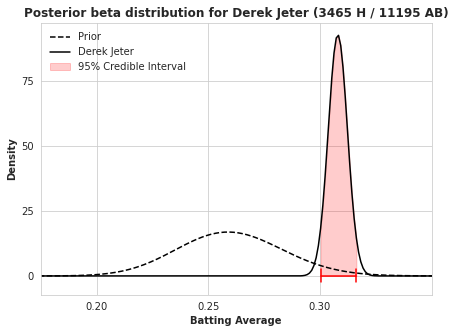

In [103]:
# Make figure
with sns.axes_style("whitegrid"):
    # Fig
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()
    clrs = sns.color_palette("colorblind",n_colors=len(players))

    # Make distributions for prior and each player
    x = np.linspace(0,1,1000)
    ax.plot(x, stats.beta.pdf(x,alpha0,beta0),color='k',linestyle='--',label="Prior")

    aa,bb = bd_trim.loc[bd_trim.Name.isin(["Derek Jeter"]),["alpha1","beta1"]].to_numpy()[0]
    djbeta = stats.beta.pdf(x,aa,bb)
    ax.plot(x,djbeta,color='k',lw=1.5,label="Derek Jeter")

    low, high = bd_trim.loc[bd_trim.Name.isin(["Derek Jeter"]),["ci_low","ci_high"]].to_numpy()[0]
    x_idx = list(np.where(np.logical_and(x > low,x < high)))[0]
    ax.fill_between(x[x_idx],djbeta[x_idx],len(x_idx)*[0],color='r',alpha=0.2,label="95% Credible Interval")
    ax.plot(x[x_idx],len(x_idx)*[0],color='r')
    ax.plot(50*[x[x_idx[0]]],np.linspace(-2.5,2.5,50),color='r')
    ax.plot(50*[x[x_idx[-1]]],np.linspace(-2.5,2.5,50),color='r')
    ax.set_xlim(0.175,0.35)

    # Add legend and clean up
    ax.legend(frameon=False)
    ax.set_title("Posterior beta distribution for Derek Jeter (3465 H / 11195 AB)",fontweight='bold')
    ax.set_xlabel("Batting Average",fontweight="bold")
    ax.set_ylabel("Density",fontweight="bold")
    ax.set_xticks([.2,.25, .3])
    ax.set_yticks([0,25,50,75])

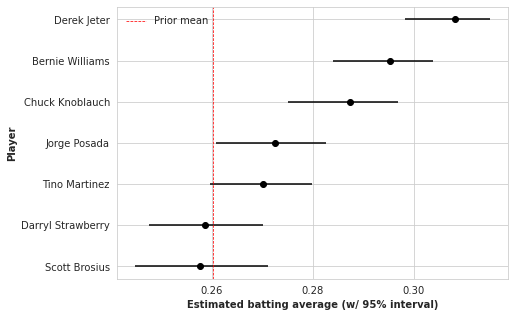

In [104]:
# Get credible intervals as list of tuples
credible_intervals = bd_trim.loc[:,["ci_low_diff","ci_high_diff"]].transpose().to_numpy()

# Make figure
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot()
    ax.errorbar(x=bd_trim.loc[:,"eb estimate Avg"],y=np.arange(len(players)),xerr=credible_intervals,color='k',fmt='o',)
    ax.axvline(x=stats.beta(alpha0,beta0).mean(),color='r',linestyle='--',lw=.75,label="Prior mean")
    # Clean up
    ax.set_xticks([0.26,0.28,0.30])
    ax.set_yticks(np.arange(len(players)))
    ax.set_yticklabels(bd_trim.Name.tolist())
    ax.set_xlabel("Estimated batting average (w/ 95% interval)",fontweight="bold")
    ax.set_ylabel("Player",fontweight="bold")
    ax.legend(frameon=False)

Now we will compute the confidence intervals.

In [107]:
# Use statsmodels for the confidence intervals
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint   


def get_confidence_intervals(data):
    # Clopper-Pearson
    xx, yy = proportion_confint(count=data["H"], nobs=data["AB"], alpha=0.05, method='beta')
    data["CI_Clopper_low"], data["CI_Clopper_high"] = xx, yy
    # Jeffreys
    xx, yy = proportion_confint(count=data["H"], nobs=data["AB"], alpha=0.05, method='jeffreys')
    data["CI_Jeffreys_low"], data["CI_Jeffreys_high"] = xx, yy
    return data
    
bd = bd.apply(get_confidence_intervals,axis=1)
bd


/Users/justinbrantley/miniconda3/envs/bayesball/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:621: RuntimeWarning: overflow encountered in _beta_isf
  return _boost._beta_isf(x, a, b)
/Users/justinbrantley/miniconda3/envs/bayesball/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)


,playerID,AB,H,Name,Avg,eb estimate Avg,alpha1,beta1,ci_low,ci_high,ci_low_diff,ci_high_diff,CI_Clopper_low,CI_Clopper_high,CI_Jeffreys_low,CI_Jeffreys_high
0,aaronha01,12364,3771,Hank Aaron,0.304998,0.303783,3860.733185,8848.130635,0.295817,0.311807,0.009181,0.006809,0.296889,0.313199,0.296929,0.313159
1,aaronto01,944,216,Tommie Aaron,0.228814,0.237211,305.733185,983.130635,0.214390,0.260805,0.014424,0.031992,0.202367,0.256963,0.202873,0.256414
2,abadan01,21,2,Andy Abad,0.095238,0.250730,91.733185,274.130635,0.207708,0.296334,0.112470,0.201096,0.011749,0.303774,0.020327,0.271911
3,abadijo01,49,11,John Abadie,0.224490,0.255756,100.733185,293.130635,0.213934,0.299928,0.010556,0.075438,0.117743,0.366243,0.125540,0.354884
4,abbated01,3044,772,Ed Abbaticchio,0.253614,0.254284,861.733185,2527.130635,0.239764,0.269079,0.013850,0.015465,0.238236,0.269466,0.238397,0.269299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9797,zuninmi01,2226,446,Mike Zunino,0.200359,0.208386,535.733185,2035.130635,0.192907,0.224296,0.007453,0.023936,0.183910,0.217602,0.184127,0.217370
9798,zupcibo01,795,199,Bob Zupcic,0.250314,0.253305,288.733185,851.130635,0.228486,0.278944,0.021829,0.028630,0.220545,0.281948,0.221147,0.281296
9799,zupofr01,18,3,Frank Zupo,0.166667,0.255559,92.733185,270.130635,0.212058,0.301612,0.045392,0.134945,0.035785,0.414177,0.049288,0.381357
9800,zuvelpa01,491,109,Paul Zuvella,0.221996,0.237758,198.733185,637.130635,0.209521,0.267183,0.012475,0.045187,0.185986,0.261392,0.186938,0.260320


,playerID,AB,H,Name,Avg,eb estimate Avg,alpha1,beta1,ci_low,ci_high,ci_low_diff,ci_high_diff,CI_Clopper_low,CI_Clopper_high,CI_Jeffreys_low,CI_Jeffreys_high
9670,wrighal01,1,1,Al Wright,1.0,0.262338,90.733185,255.130635,0.217387,0.309892,0.782613,0.690108,0.025000,1.000000,0.146746,0.999614
6985,pickuty01,1,1,Ty Pickup,1.0,0.262338,90.733185,255.130635,0.217387,0.309892,0.782613,0.690108,0.025000,1.000000,0.146746,0.999614
9327,wattal01,1,1,Allie Watt,1.0,0.262338,90.733185,255.130635,0.217387,0.309892,0.782613,0.690108,0.025000,1.000000,0.146746,0.999614
4856,kuczest01,1,1,Steve Kuczek,1.0,0.262338,90.733185,255.130635,0.217387,0.309892,0.782613,0.690108,0.025000,1.000000,0.146746,0.999614
5130,lindsch02,1,1,Charlie Lindstrom,1.0,0.262338,90.733185,255.130635,0.217387,0.309892,0.782613,0.690108,0.025000,1.000000,0.146746,0.999614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1159,burkejo01,10,5,Joe Burke,0.5,0.266956,94.733185,260.130635,0.222279,0.314122,0.277721,0.185878,0.187086,0.812914,0.223529,0.776471
1165,burkma01,2,1,Mack Burk,0.5,0.261582,90.733185,256.130635,0.216741,0.309026,0.283259,0.190974,0.012579,0.987421,0.060830,0.939170
5871,meixemo01,2,1,Moxie Meixell,0.5,0.261582,90.733185,256.130635,0.216741,0.309026,0.283259,0.190974,0.012579,0.987421,0.060830,0.939170
5069,leovijo01,2,1,John Leovich,0.5,0.261582,90.733185,256.130635,0.216741,0.309026,0.283259,0.190974,0.012579,0.987421,0.060830,0.939170


['Henry Oxley (0/7)',
 'Chuck Wortman (82/441)',
 'Ray Blades (726/2415)',
 'John Boccabella (320/1462)',
 'Vic Roznovsky (99/455)',
 'Wyatt Toregas (9/55)',
 'Carl Nichols (38/186)',
 'Jimmie Reese (206/742)',
 'Wally Smith (117/510)',
 'Joe Charboneau (172/647)',
 'John Valentin (1093/3917)',
 'Pete Runnels (1854/6373)',
 'Buddy Ryan (161/571)',
 'Rocco Baldelli (531/1910)',
 'George Lees (9/42)',
 'Matt Duffy (3/11)',
 'Steve Evans (963/3359)',
 'Doc Edwards (216/906)',
 'Gorkys Hernandez (227/988)',
 'Mike Sandlock (107/446)']

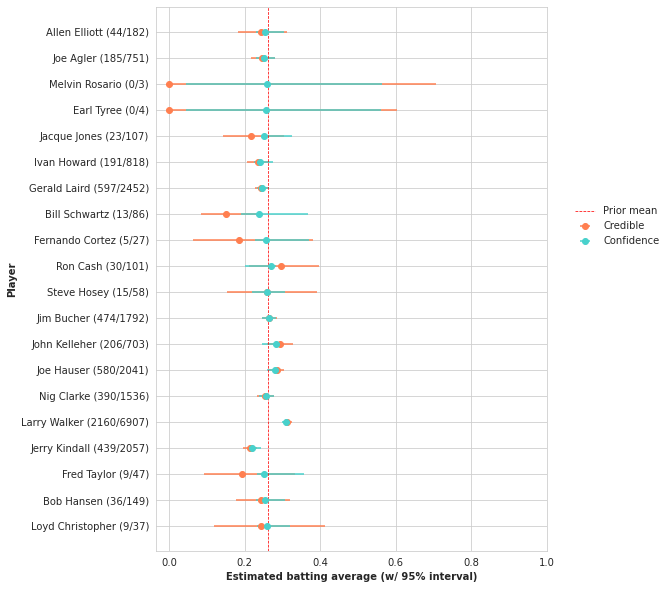

In [132]:
# Get credible intervals as list of tuples
bd_rand = bd.sample(20).copy()
credible_intervals = bd_rand.loc[:,["ci_low_diff","ci_high_diff"]].transpose().to_numpy()
confidence_intervals = np.vstack((np.absolute(bd_rand.loc[:,"CI_Clopper_low"] - bd_rand.loc[:,"Avg"]),np.absolute(bd_rand.loc[:,"CI_Clopper_high"] - bd_rand.loc[:,"Avg"])))

# Make figure
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(7,10))
    ax = fig.add_subplot()
    ax.errorbar(x=bd_rand.loc[:,"Avg"],y=np.arange(len(bd_rand)),xerr=confidence_intervals,color='coral',fmt='o',label="Credible")
    ax.errorbar(x=bd_rand.loc[:,"eb estimate Avg"],y=np.arange(len(bd_rand)),xerr=credible_intervals,color='mediumturquoise',fmt='o',label="Confidence")
    ax.axvline(x=stats.beta(alpha0,beta0).mean(),color='r',linestyle='--',lw=.75,label="Prior mean")
    # Clean up
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_yticks(np.arange(len(bd_rand)))
   
    def make_name_with_H_AB(zipped_up):
        name, AB, H = zipped_up
        return name + " " + "(" + str(H) + "/" + str(AB) + ")"

    yticklabs = [make_name_with_H_AB(ii) for ii in zip(bd_rand.Name.to_list(), bd_rand.AB.to_list(), bd_rand.H.to_list())]
    ax.set_yticklabels(yticklabs)
    ax.set_xlabel("Estimated batting average (w/ 95% interval)",fontweight="bold")
    ax.set_ylabel("Player",fontweight="bold")
    ax.legend(frameon=False,bbox_to_anchor=(1.05, .65),loc='upper left')
